# Abundance Uncertainties in APOGEE

Baseline for the uncertainty function to convolve with VICE outputs before plotting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [156]:
# Plot settings
plt.rcParams.update({
    'xtick.direction': 'in',
    'xtick.top': True,
    'ytick.direction': 'in',
    'ytick.right': True,
    'figure.dpi': 140,
    'figure.figsize': (4, 4),
})

In [8]:
data = pd.read_csv('../src/data/APOGEE/sample.csv')
data

,APOGEE_ID,RA,DEC,GALR,GALPHI,GALZ,SNREV,TEFF,TEFF_ERR,LOGG,LOGG_ERR,FE_H,FE_H_ERR,O_FE,O_FE_ERR,ASTRONN_AGE,ASTRONN_AGE_ERR,LATENT_AGE,LATENT_AGE_ERR
0,2M00000068+5710233,0.002850,57.173164,8.458404,175.658285,-0.040749,282.74594,5031.2637,10.145057,3.456132,0.023554,-0.160280,0.006890,0.113698,0.023433,6.705514,1.256932,3.713866,1.315107
1,2M00000133+5721163,0.005558,57.354549,11.953869,153.654715,-0.470835,120.29548,4974.6010,15.310856,2.388251,0.035517,-0.509530,0.011012,0.185943,0.039313,4.633531,2.296918,NaN,NaN
2,2M00000211+6327470,0.008802,63.463078,12.858291,151.396933,0.169356,169.02042,4681.4634,8.766338,2.245527,0.024334,-0.075011,0.008396,0.027783,0.016560,1.957528,0.724621,NaN,NaN
3,2M00000222+5625359,0.009287,56.426662,9.217623,168.311742,-0.185231,129.40749,5049.7686,14.194268,3.291666,0.029259,-0.139290,0.009310,0.087976,0.033478,2.314873,0.814782,1.241603,0.066435
4,2M00000446+5854329,0.018603,58.909149,10.505168,160.196856,-0.203834,144.98238,4766.6274,10.474075,2.420902,0.026512,-0.082189,0.009157,0.043742,0.020672,2.884895,0.617445,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192915,2M23595669+6131251,359.986225,61.523659,9.939371,163.650440,-0.015894,154.12479,5008.3950,13.106046,2.480740,0.030519,-0.408670,0.009130,-0.031660,0.032894,7.702965,1.889179,NaN,NaN
192916,2M23595676+7918072,359.986523,79.302002,9.415115,168.484293,0.676923,446.47790,4311.3926,6.555767,1.731429,0.026187,-0.504450,0.009010,0.287303,0.012854,1.054230,0.843403,NaN,NaN
192917,2M23595837+5700444,359.993224,57.012356,10.694221,159.021606,-0.358826,101.53675,4954.1700,15.750314,2.474665,0.034748,-0.333100,0.011422,0.130718,0.037808,4.059420,2.462703,NaN,NaN
192918,2M23595886+5726058,359.995265,57.434956,9.328103,167.511337,-0.163006,232.91826,4859.9087,9.050734,2.480687,0.024013,-0.236560,0.007337,0.088913,0.019459,1.907065,0.720498,NaN,NaN


## [Fe/H]

In [121]:
xcol = 'FE_H'
ycol = xcol+'_ERR'
bincol = xcol+'_BIN'
# Median error in bins of [Fe/H]
bin_width = 0.1
bin_edges = np.arange(-2.5, 0.7, bin_width)
bin_centers = bin_edges[:-1] + bin_width/2
# group by [Fe/H] bin
data[xcol+'_BIN'] = pd.cut(data[xcol], bin_edges, labels=bin_centers)
grouped = data.groupby(bincol)
# median and percentiles
medians = grouped[ycol].median()
err1 = grouped[ycol].quantile(0.84) - medians
err2 = medians - grouped[ycol].quantile(0.16)
# RMS standard deviation
stdev = np.sqrt(err1**2 + err2**2)
# linear model fit
linear_fit = np.poly1d(np.polyfit(bin_centers, medians, 1, w=1/stdev))
# quadratic fit
quad_fit = np.poly1d(np.polyfit(bin_centers, medians, 2, w=1/stdev))
# cubic fit
cubic_fit = np.poly1d(np.polyfit(bin_centers, medians, 3, w=1/stdev))

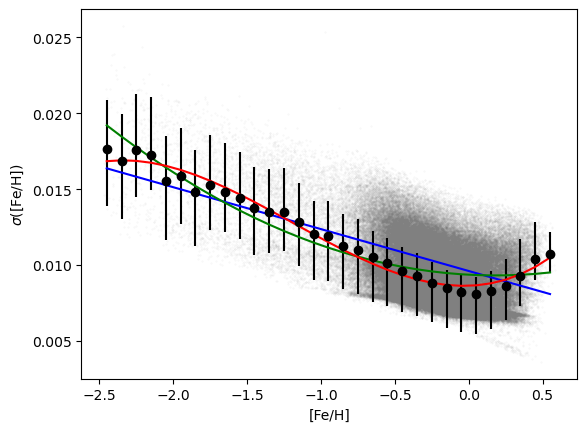

In [122]:
fig, ax = plt.subplots()
ax.scatter(data[xcol], data[ycol], alpha=0.1, s=0.1, c='gray')
ax.errorbar(bin_centers, medians, yerr=(err1, err2),
            linestyle='none', marker='o', color='k')
ax.plot(bin_centers, linear_fit(bin_centers), 'b-')
ax.plot(bin_centers, quad_fit(bin_centers), 'g-')
ax.plot(bin_centers, cubic_fit(bin_centers), 'r-')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel(r'$\sigma$([Fe/H])')
plt.show()

In [123]:
feh_err_fit = linear_fit

## [O/Fe]

In [135]:
xcol = 'O_FE'
ycol = xcol+'_ERR'
bincol = xcol+'_BIN'
# data bins
bin_width = 0.1
bin_edges = np.arange(-0.25, 0.75, bin_width)
bin_centers = bin_edges[:-1] + bin_width/2
# group by bin
data[xcol+'_BIN'] = pd.cut(data[xcol], bin_edges, labels=bin_centers)
grouped = data.groupby(bincol)
# median and percentiles
medians = grouped[ycol].median()
err1 = grouped[ycol].quantile(0.84) - medians
err2 = medians - grouped[ycol].quantile(0.16)
# RMS standard deviation
stdev = np.sqrt(err1**2 + err2**2)
# linear model fit
linear_fit = np.poly1d(np.polyfit(bin_centers, medians, 1, w=1/stdev))
# quadratic fit
quad_fit = np.poly1d(np.polyfit(bin_centers, medians, 2, w=1/stdev))
# cubic fit
cubic_fit = np.poly1d(np.polyfit(bin_centers, medians, 3, w=1/stdev))

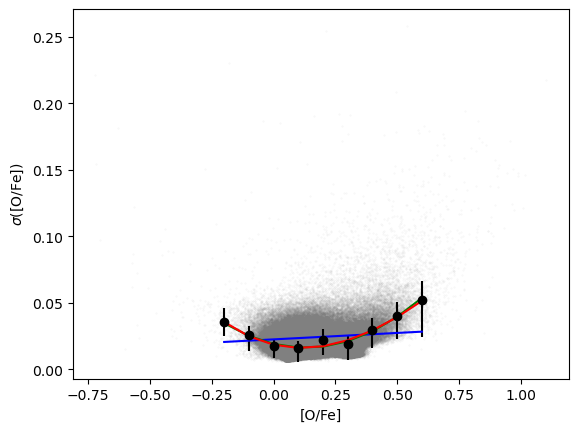

In [136]:
fig, ax = plt.subplots()
ax.scatter(data[xcol], data[ycol], alpha=0.1, s=0.1, c='gray')
ax.errorbar(bin_centers, medians, yerr=(err1, err2),
            linestyle='none', marker='o', color='k')
ax.plot(bin_centers, linear_fit(bin_centers), 'b-')
ax.plot(bin_centers, quad_fit(bin_centers), 'g-')
ax.plot(bin_centers, cubic_fit(bin_centers), 'r-')
ax.set_xlabel('[O/Fe]')
ax.set_ylabel(r'$\sigma$([O/Fe])')
plt.show()

In [137]:
ofe_err_fit = linear_fit

## Age (Leung+ 2023)

In [127]:
ages = data.copy().dropna(subset='LATENT_AGE')
ages

,APOGEE_ID,RA,DEC,GALR,GALPHI,GALZ,SNREV,TEFF,TEFF_ERR,LOGG,...,FE_H,FE_H_ERR,O_FE,O_FE_ERR,ASTRONN_AGE,ASTRONN_AGE_ERR,LATENT_AGE,LATENT_AGE_ERR,FE_H_BIN,O_FE_BIN
0,2M00000068+5710233,0.002850,57.173164,8.458404,175.658285,-0.040749,282.745940,5031.2637,10.145057,3.456132,...,-0.160280,0.006890,0.113698,0.023433,6.705514,1.256932,3.713866,1.315107,-0.15,1.000000e-01
3,2M00000222+5625359,0.009287,56.426662,9.217623,168.311742,-0.185231,129.407490,5049.7686,14.194268,3.291666,...,-0.139290,0.009310,0.087976,0.033478,2.314873,0.814782,1.241603,0.066435,-0.15,1.000000e-01
5,2M00000506+5656353,0.021113,56.943142,10.782479,158.585472,-0.375009,533.233700,4981.5250,10.393430,2.527178,...,-0.427070,0.007515,0.085135,0.025435,2.470570,1.266172,3.081407,1.245757,-0.45,1.000000e-01
6,2M00000535+1504343,0.022311,15.076210,8.381313,174.422544,-0.851532,162.739610,4914.6753,10.838367,3.300559,...,-0.087559,0.008191,0.101433,0.023082,7.667747,0.803533,4.828175,1.366519,-0.05,1.000000e-01
8,2M00000644+5733530,0.026870,57.564724,9.838391,163.937207,-0.220741,173.442660,4757.3230,9.079043,2.575232,...,-0.065082,0.008055,-0.017343,0.017650,2.438767,0.699191,3.041128,1.276580,-0.05,1.387779e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192905,2M23595371+8506304,359.973792,85.108459,9.151392,170.735256,0.735716,159.313220,5092.2430,12.708504,3.379881,...,-0.112140,0.008028,0.088694,0.030328,2.993673,0.950974,2.848126,0.609402,-0.15,1.000000e-01
192907,2M23595481+7509560,359.978414,75.165581,8.616469,174.634896,0.229559,498.815370,4824.3516,9.166178,2.718271,...,-0.395240,0.007764,0.189403,0.020430,5.824268,1.271910,6.429371,2.465394,-0.35,2.000000e-01
192908,2M23595490+5704387,359.978770,57.077431,8.585246,174.234470,-0.063616,585.913000,5015.4077,9.502117,2.892750,...,0.050932,0.006490,-0.115146,0.020192,0.720682,0.215777,0.822008,0.116917,0.05,-1.000000e-01
192913,2M23595553+6339020,359.981416,63.650566,10.086408,162.964682,0.102936,106.809425,5003.4780,14.522411,2.998743,...,0.042468,0.009845,-0.005199,0.031410,0.889073,0.302168,0.884344,0.187022,0.05,1.387779e-17


In [138]:
xcol = 'LATENT_AGE'
ycol = xcol+'_ERR'
bincol = xcol+'_BIN'
# data bins
bin_width = 2
bin_edges = np.arange(1, 15, bin_width)
bin_centers = bin_edges[:-1] + bin_width/2
# group by bin
ages[xcol+'_BIN'] = pd.cut(ages[xcol], bin_edges, labels=bin_centers)
grouped = ages.groupby(bincol)
# median and percentiles
medians = grouped[ycol].median()
err1 = grouped[ycol].quantile(0.84) - medians
err2 = medians - grouped[ycol].quantile(0.16)

In [139]:

# RMS standard deviation
stdev = np.sqrt(err1**2 + err2**2)
# linear model fit
linear_fit = np.poly1d(np.polyfit(bin_centers, medians, 1, w=1/stdev))
# quadratic fit
quad_fit = np.poly1d(np.polyfit(bin_centers, medians, 2, w=1/stdev))
# cubic fit
cubic_fit = np.poly1d(np.polyfit(bin_centers, medians, 3, w=1/stdev))

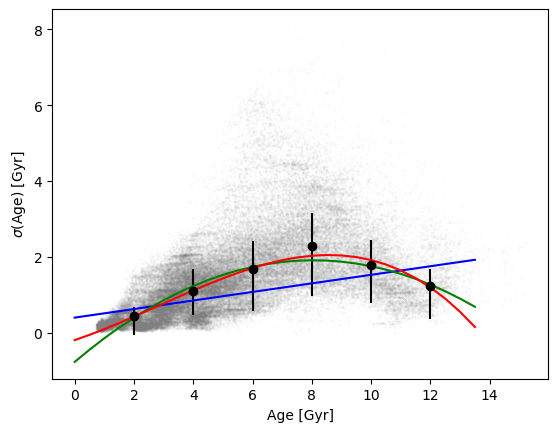

In [140]:
fig, ax = plt.subplots()
ax.scatter(ages[xcol], ages[ycol], alpha=0.1, s=0.1, c='gray')
ax.errorbar(bin_centers, medians, yerr=(err1, err2),
            linestyle='none', marker='o', color='k')
xarr = np.arange(0, 14, 0.5)
ax.plot(xarr, linear_fit(xarr), 'b-')
ax.plot(xarr, quad_fit(xarr), 'g-')
ax.plot(xarr, cubic_fit(xarr), 'r-')
ax.set_xlabel('Age [Gyr]')
ax.set_ylabel(r'$\sigma$(Age) [Gyr]')
plt.show()

In [141]:
age_err_fit = linear_fit

## Test with VICE output

In [180]:
import sys
import os
sys.path.append(os.path.abspath('../src/scripts'))
from utils import multioutput_to_pandas, filter_multioutput_stars, get_bin_centers
from feh_distribution import gen_mdf, box_smooth

In [211]:
output_name = 'diffusion/conroy22/plateau_width300_slope11'
stars = multioutput_to_pandas(output_name, data_dir='../src/data/migration/')
subset = filter_multioutput_stars(stars, galr_lim=(7, 9), absz_lim=(0, 0.5))
subset

,index,formation_time,zone_origin,zone_final,mass,z(fe),z(o),[fe/h],[o/h],[o/fe],z,[m/h],age,analog_id,zfinal,galr_origin
0,85336,0.53,67.0,76.0,2196.048,0.000003,0.000055,-2.594731,-2.017172,0.577559,0.000116,-2.080330,12.67,27143999,0.37,6.7
1,85340,0.53,67.0,76.0,2196.048,0.000003,0.000055,-2.594731,-2.017172,0.577559,0.000116,-2.080330,12.67,27143999,0.37,6.7
2,85346,0.53,68.0,77.0,2161.983,0.000003,0.000051,-2.623505,-2.047492,0.576013,0.000109,-2.110563,12.67,27143999,0.37,6.8
3,85353,0.53,69.0,78.0,1992.727,0.000003,0.000047,-2.659013,-2.081145,0.577868,0.000100,-2.144320,12.67,27143999,0.37,6.9
4,85362,0.53,70.0,79.0,1830.130,0.000003,0.000044,-2.693524,-2.112399,0.581125,0.000093,-2.175757,12.67,27143999,0.37,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116918,2112715,13.20,89.0,89.0,22465.420,0.001499,0.006601,0.065086,0.062244,-0.002841,0.016177,0.062769,0.00,35027105,-0.04,8.9
116919,2112716,13.20,89.0,89.0,22465.420,0.001499,0.006601,0.065086,0.062244,-0.002841,0.016177,0.062769,0.00,34973237,0.14,8.9
116920,2112717,13.20,89.0,89.0,22465.420,0.001499,0.006601,0.065086,0.062244,-0.002841,0.016177,0.062769,0.00,35028620,-0.02,8.9
116921,2112718,13.20,89.0,89.0,22465.420,0.001499,0.006601,0.065086,0.062244,-0.002841,0.016177,0.062769,0.00,35018664,-0.07,8.9


In [212]:
rng = np.random.default_rng()
feh_noise = rng.normal(loc=0., scale=feh_err_fit(subset['[fe/h]']), size=subset.shape[0])
subset['feh_noisy'] = subset['[fe/h]'] + feh_noise
subset

,index,formation_time,zone_origin,zone_final,mass,z(fe),z(o),[fe/h],[o/h],[o/fe],z,[m/h],age,analog_id,zfinal,galr_origin,feh_noisy
0,85336,0.53,67.0,76.0,2196.048,0.000003,0.000055,-2.594731,-2.017172,0.577559,0.000116,-2.080330,12.67,27143999,0.37,6.7,-2.609170
1,85340,0.53,67.0,76.0,2196.048,0.000003,0.000055,-2.594731,-2.017172,0.577559,0.000116,-2.080330,12.67,27143999,0.37,6.7,-2.615471
2,85346,0.53,68.0,77.0,2161.983,0.000003,0.000051,-2.623505,-2.047492,0.576013,0.000109,-2.110563,12.67,27143999,0.37,6.8,-2.622798
3,85353,0.53,69.0,78.0,1992.727,0.000003,0.000047,-2.659013,-2.081145,0.577868,0.000100,-2.144320,12.67,27143999,0.37,6.9,-2.672693
4,85362,0.53,70.0,79.0,1830.130,0.000003,0.000044,-2.693524,-2.112399,0.581125,0.000093,-2.175757,12.67,27143999,0.37,7.0,-2.701274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116918,2112715,13.20,89.0,89.0,22465.420,0.001499,0.006601,0.065086,0.062244,-0.002841,0.016177,0.062769,0.00,35027105,-0.04,8.9,0.083936
116919,2112716,13.20,89.0,89.0,22465.420,0.001499,0.006601,0.065086,0.062244,-0.002841,0.016177,0.062769,0.00,34973237,0.14,8.9,0.076829
116920,2112717,13.20,89.0,89.0,22465.420,0.001499,0.006601,0.065086,0.062244,-0.002841,0.016177,0.062769,0.00,35028620,-0.02,8.9,0.056640
116921,2112718,13.20,89.0,89.0,22465.420,0.001499,0.006601,0.065086,0.062244,-0.002841,0.016177,0.062769,0.00,35018664,-0.07,8.9,0.067191


In [213]:
ofe_noise = rng.normal(loc=0., scale=ofe_err_fit(subset['[o/fe]']), size=subset.shape[0])
subset['ofe_noisy'] = subset['[o/fe]'] + ofe_noise
age_noise = rng.normal(loc=0., scale=age_err_fit(subset['age']), size=subset.shape[0])
subset['age_noisy'] = np.abs(subset['age'] + age_noise)

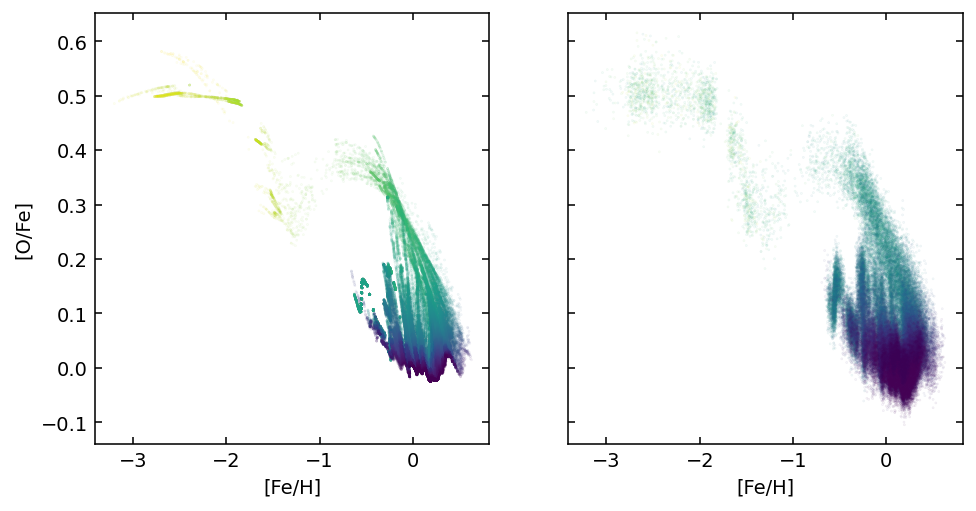

In [214]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=140, sharex=True, sharey=True)
axs[0].scatter(subset['[fe/h]'], subset['[o/fe]'], c=subset['age'], s=0.1, alpha=0.1)
axs[0].set_xlabel('[Fe/H]')
axs[0].set_ylabel('[O/Fe]')

axs[1].scatter(subset['feh_noisy'], subset['ofe_noisy'], c=subset['age_noisy'], s=0.1, alpha=0.1)
axs[1].set_xlabel('[Fe/H]')
plt.show()

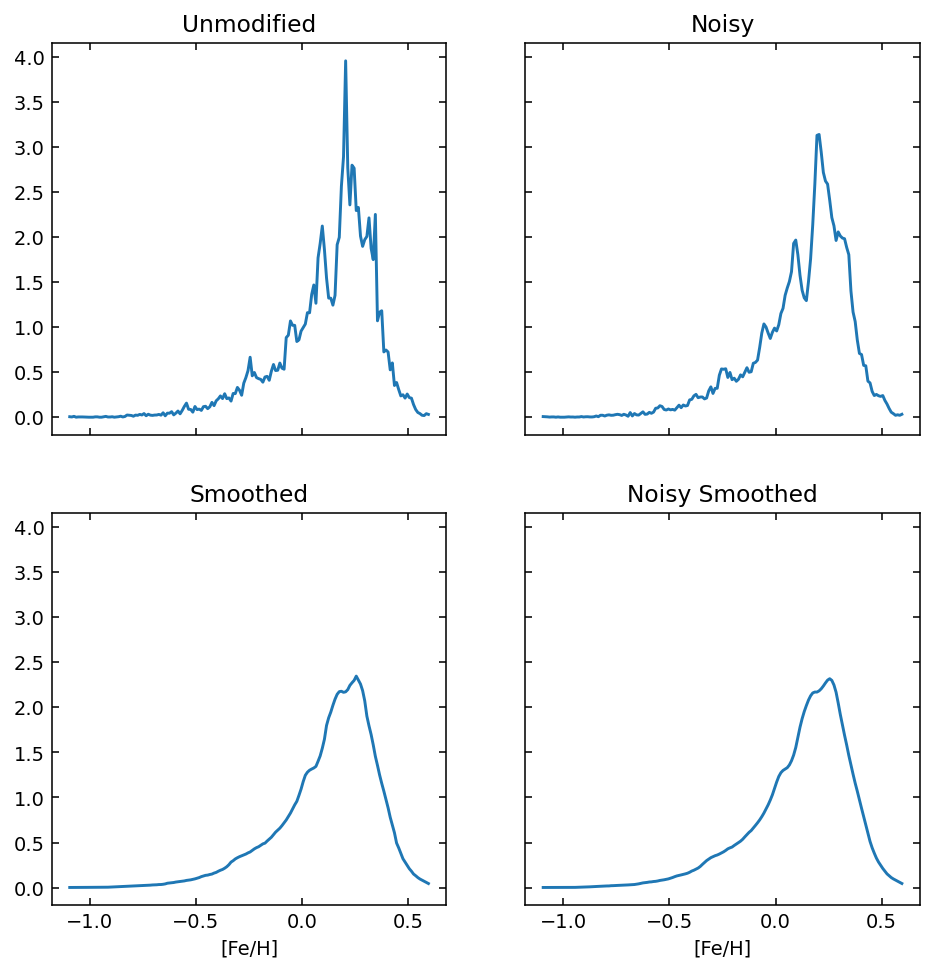

In [215]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=140, sharex=True, sharey=True)
# original VICE output
mdf_clean, bins = gen_mdf(subset, col='[fe/h]', range=(-1.1, 0.6), bin_width=0.01)
bin_centers = get_bin_centers(bins)
axs[0,0].plot(bin_centers, mdf_clean)
axs[0,0].set_title('Unmodified')
# noisy output
mdf_noisy, bins = gen_mdf(subset, col='feh_noisy', range=(-1.1, 0.6), bin_width=0.01)
axs[0,1].plot(bin_centers, mdf_noisy)
axs[0,1].set_title('Noisy')
# original smoothed
mdf_smooth = box_smooth(mdf_clean, bins, 0.2)
axs[1,0].plot(bin_centers, mdf_smooth)
axs[1,0].set_xlabel('[Fe/H]')
axs[1,0].set_title('Smoothed')
# noisy smoothed
mdf_noisy_smooth = box_smooth(mdf_noisy, bins, 0.2)
axs[1,1].plot(bin_centers, mdf_noisy_smooth)
axs[1,1].set_xlabel('[Fe/H]')
axs[1,1].set_title('Noisy Smoothed')
plt.show()

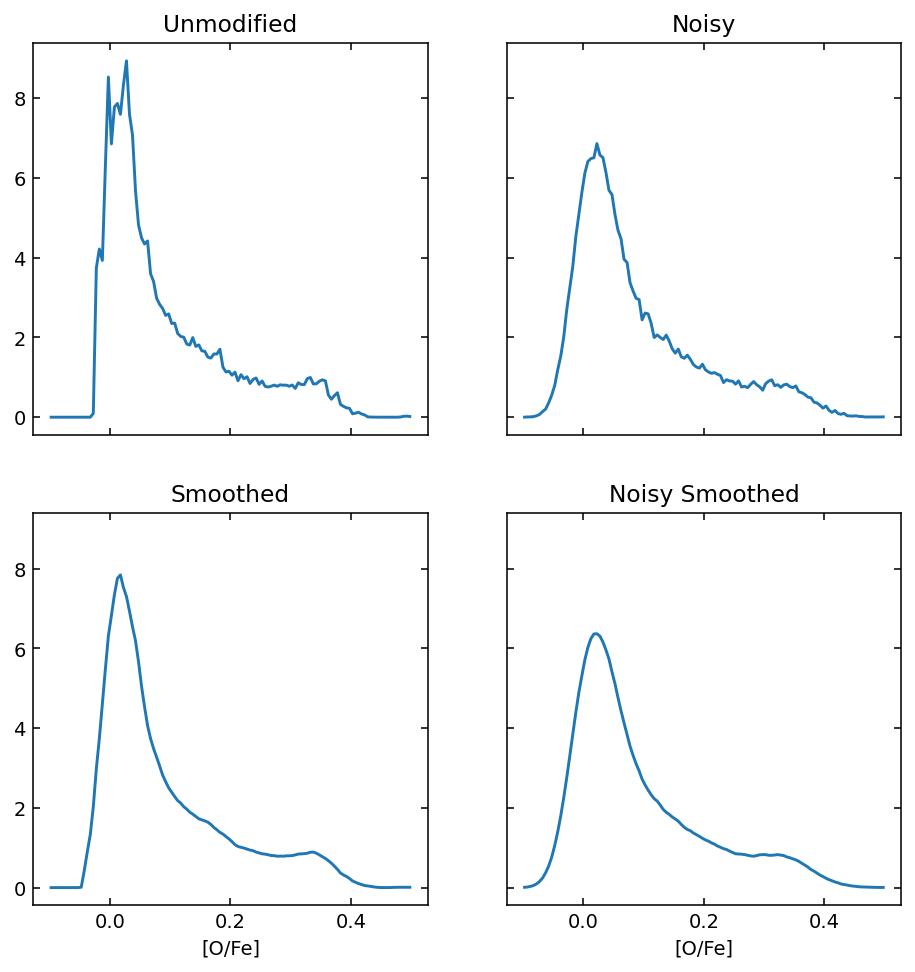

In [216]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=140, sharex=True, sharey=True)
# original VICE output
mdf_clean, bins = gen_mdf(subset, col='[o/fe]', range=(-0.1, 0.5), bin_width=0.005)
bin_centers = get_bin_centers(bins)
axs[0,0].plot(bin_centers, mdf_clean)
axs[0,0].set_title('Unmodified')
# noisy output
mdf_noisy, bins = gen_mdf(subset, col='ofe_noisy', range=(-0.1, 0.5), bin_width=0.005)
axs[0,1].plot(bin_centers, mdf_noisy)
axs[0,1].set_title('Noisy')
# original smoothed
mdf_smooth = box_smooth(mdf_clean, bins, 0.05)
axs[1,0].plot(bin_centers, mdf_smooth)
axs[1,0].set_xlabel('[O/Fe]')
axs[1,0].set_title('Smoothed')
# noisy smoothed
mdf_noisy_smooth = box_smooth(mdf_noisy, bins, 0.05)
axs[1,1].plot(bin_centers, mdf_noisy_smooth)
axs[1,1].set_xlabel('[O/Fe]')
axs[1,1].set_title('Noisy Smoothed')
plt.show()

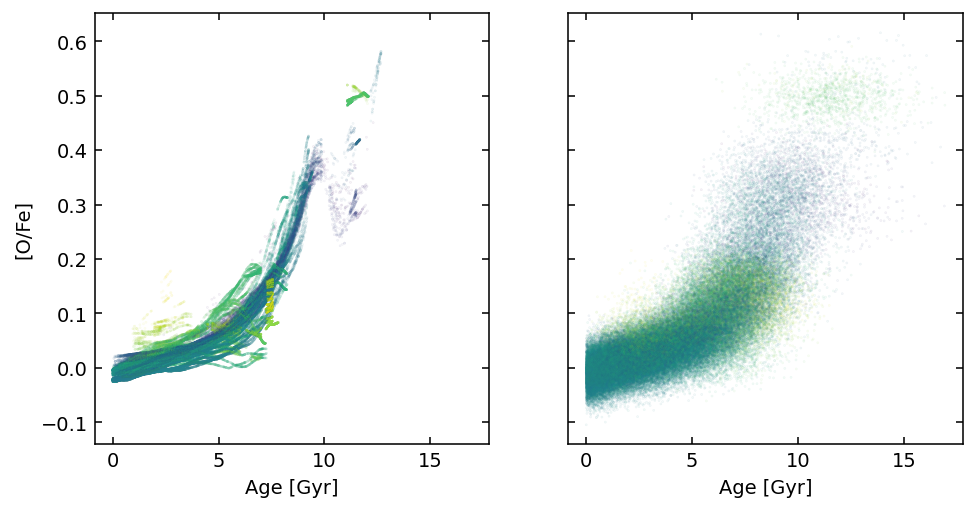

In [217]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=140, sharex=True, sharey=True)
axs[0].scatter(subset['age'], subset['[o/fe]'], c=subset['galr_origin'], s=0.1, alpha=0.1)
axs[0].set_xlabel('Age [Gyr]')
axs[0].set_ylabel('[O/Fe]')

axs[1].scatter(subset['age_noisy'], subset['ofe_noisy'], c=subset['galr_origin'], s=0.1, alpha=0.1)
axs[1].set_xlabel('Age [Gyr]')
plt.show()